In [ ]:
# core di test per PARK

In [2]:
# Configuro le variabili d'ambiente
#

import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

DATA_FORLDER_TRN = "./data/4Park/train/"
DATA_FORLDER_TST = "./data/4Park/test/"
BATCH_SIZE = 32
AUTOTUNE = tf.data.AUTOTUNE

In [4]:
# caricamento dei dataset di traing / test da file system
def load_ds(data_folder=None, subset=None):
    if data_folder == None:
        return None
    
    if subset == None or subset == 'full':
        vsplit = 0.0
    else:
        vsplit = 0.2

    return tf.keras.utils.image_dataset_from_directory(
        data_folder,
        labels='inferred',
        label_mode='binary',
        class_names=('free', 'busy'),
        color_mode='rgb',
        batch_size=BATCH_SIZE,
        image_size=(150,150),
        shuffle=True,
        seed=311,
        validation_split=vsplit,
        subset=subset,
        interpolation='bilinear',
        follow_links=False,
        crop_to_aspect_ratio=False    
    )

def info_ds(name, ds):
    bsize = tf.data.experimental.cardinality(ds)
    print(f'{name} [{len(ds.file_paths)}]')

train_ds = load_ds(DATA_FORLDER_TRN, 'training')
valid_ds = load_ds(DATA_FORLDER_TRN, 'validation')

class_names = train_ds.class_names #type: ignore
print(class_names)
print(f'Train DS size {len(train_ds.file_paths)}')
print(f'Valid DS size {len(valid_ds.file_paths)}')

Found 693851 files belonging to 2 classes.
Using 555081 files for training.
Found 693851 files belonging to 2 classes.
Using 138770 files for validation.
Found 2000 files belonging to 2 classes.
('free', 'busy')
Train DS size 555081
Valid DS size 138770
Test  DS size 2000


2023-04-03 15:25:40.922757: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


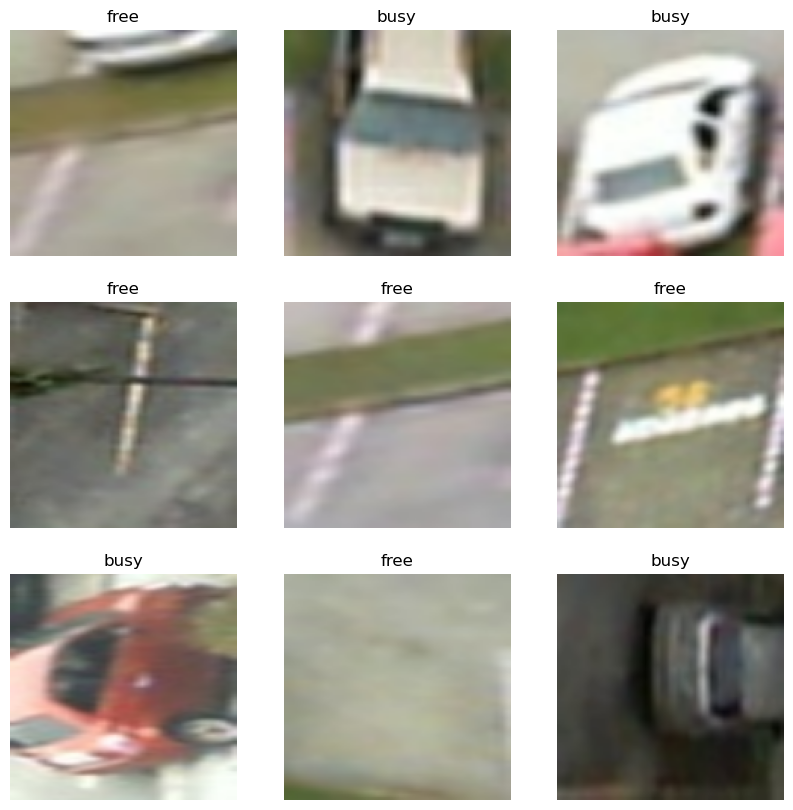

In [4]:
# prendiamo qualche immagine a caso per 'visualizzare' il campione

plt.figure(figsize=(10,10))

for imgs, lbls in train_ds.take(1):
    for i in range(9):
        img = imgs[i].numpy().astype('uint8')
        lbl = lbls[i].numpy().astype('int')[0]
        ax = plt.subplot(3, 3, i+1)
        plt.imshow(img)
        plt.title(class_names[lbl])
        plt.axis(False)

In [5]:
# normalizzazione dei dati
normalization_layer = Sequential([
    tf.keras.layers.Resizing(width=150, height=150),
    tf.keras.layers.Rescaling(1./255),
])

augmentation_layer = None # le augmentation generano problemi su MAC...
# ISSUE WITH AUGMENTERS!!
# https://github.com/tensorflow/tensorflow/issues/55639#issuecomment-1310229476
# there was a bunch of problem related with augmentation and keras
# implementation, the core problem same to be related with the vectorialized_map implementation
# as to date 8 gen 2023 the problem is still present...
#
# augmentation_layer = Sequential([
#    #layers.RandomFlip('vertical')
#    #layers.RandomRotation(0.1),
#    #layers.RandomTranslation(width_factor=0.5, height_factor=0.)
#])

def prepare_data(ds, shuffle=False, augmenter=None, batch_size=BATCH_SIZE):
    if shuffle:
        ds.shuffle(1000)

    if normalization_layer != None:
        ds = ds.map(lambda x, y: (normalization_layer(x), y), num_parallel_calls=AUTOTUNE)

    if augmenter != None:
        ds = ds.map(lambda x, y: (augmenter(x), y), num_parallel_calls=AUTOTUNE)

    return ds


In [7]:
# Creo la CNN 4Park

model = Sequential([
    layers.Input((150, 150, 3)),
    layers.Rescaling(1./255),
    layers.Normalization(axis=[1]),
    layers.Conv2D(128, 3, activation='relu'),
    layers.MaxPooling2D(pool_size=2),
    layers.Dropout(0.2),
    layers.Conv2D(128, 3, activation='relu'),
    layers.MaxPooling2D(pool_size=2),
    layers.Dropout(0.2),
    layers.Conv2D(128, 3, activation='relu'),
    layers.MaxPooling2D(pool_size=2),
    layers.Dropout(0.2),
    layers.Conv2D(128, 3, activation='relu'),
    layers.MaxPooling2D(pool_size=2),
    layers.Dropout(0.2),
    layers.Flatten(),
    layers.Dense(64),
    #layers.Dropout(0.3),
    layers.Dense(len(class_names))
])

In [8]:
# Compilo il model

model.build()
model.compile(
    optimizer = 'adam',
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics = ['accuracy']
)

model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_2 (Rescaling)     (None, 150, 150, 3)       0         
                                                                 
 normalization_1 (Normalizat  (None, 150, 150, 3)      301       
 ion)                                                            
                                                                 
 conv2d_4 (Conv2D)           (None, 148, 148, 128)     3584      
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 74, 74, 128)      0         
 2D)                                                             
                                                                 
 dropout_4 (Dropout)         (None, 74, 74, 128)       0         
                                                                 
 conv2d_5 (Conv2D)           (None, 72, 72, 128)      

In [9]:
# Faccio il training della CNN

model.fit(
    train_ds,
    validation_data = valid_ds,
    epochs = 5
)

#model.save('4part-ext.h5')

Epoch 1/5


2023-04-03 15:43:44.541813: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


17347/17347 [==============================] - ETA: 0s - loss: 0.0278 - accuracy: 0.9922

2023-04-03 16:01:19.405704: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


17347/17347 [==============================] - 1158s 66ms/step - loss: 0.0278 - accuracy: 0.9922 - val_loss: 0.0180 - val_accuracy: 0.9959
Epoch 2/5
17347/17347 [==============================] - 2501s 144ms/step - loss: 0.0137 - accuracy: 0.9970 - val_loss: 0.0256 - val_accuracy: 0.9911
Epoch 3/5
17347/17347 [==============================] - 3013s 174ms/step - loss: 0.0117 - accuracy: 0.9975 - val_loss: 0.0488 - val_accuracy: 0.9818
Epoch 4/5
17347/17347 [==============================] - 1147s 66ms/step - loss: 0.0108 - accuracy: 0.9977 - val_loss: 0.0182 - val_accuracy: 0.9943
Epoch 5/5
17347/17347 [==============================] - 1147s 66ms/step - loss: 0.0104 - accuracy: 0.9978 - val_loss: 0.0329 - val_accuracy: 0.9882


In [5]:
# Valutiamo il modello su un test set separato

# --> vedi 4park-analizer.ipynb

2023-04-03 19:22:55.486655: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2023-04-03 19:22:55.486871: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


63/63 [==============================] - 4s 26ms/step - loss: 0.0259 - accuracy: 0.9895
[0.025879811495542526, 0.9894999861717224]
